In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

# from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention



In [2]:
import numpy as np
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

class Encodeur(tf.keras.layers.Layer):
    def __init__(self, n_layers, d_model, num_heads, middle_units,
                 max_seq_len, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
        super(Encodeur, self).__init__(**kwargs)
        self.n_layers = n_layers

        self.embedding_position = EncodagePosition(sequence_len=max_seq_len, embedding_dim=d_model)
        self.couche_encode = [CoucheEncodeur(d_model=d_model, num_heads=num_heads, max_seq_len=max_seq_len,
                                            middle_units=middle_units, epsilon=epsilon, 
                                            dropout_rate=dropout_rate, training=training)
                             for _ in range(n_layers)]

    def call(self, inputs, **kwargs):
        emb, masque = inputs
        emb = self.embedding_position(emb)
        for i in range(self.n_layers):
            emb = self.couche_encode[i](emb, masque)
        return emb

class CoucheEncodeur(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_seq_len, middle_units, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
        super(CoucheEncodeur, self).__init__(**kwargs)

        self.mha = AttentionMultiTete(num_heads)
        self.ffn = reseau_transformation_point_a_point(d_model, middle_units)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=epsilon)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=epsilon)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

        self.training = training

    def call(self, inputs, masque, **kwargs):
        # Réseau d'attention multi-tête
        sortie_att = self.mha([inputs, inputs, inputs, masque])
        sortie_att = self.dropout1(sortie_att, training=self.training)
        out1 = self.layernorm1(inputs + sortie_att)

        # Réseau de transformation point à point
        sortie_ffn = self.ffn(out1)
        sortie_ffn = self.dropout2(sortie_ffn, training=self.training)
        out2 = self.layernorm2(out1 + sortie_ffn)

        return out2

def reseau_transformation_point_a_point(numUnits, middle_units):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(middle_units, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(numUnits, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LayerNormalization()
    ])

def attention_produit_scalaire_equilibre(q, k, v, masque):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dim_k = tf.cast(tf.shape(k)[-1], tf.float32)
    attention_logits_mis_a_echelle = matmul_qk / tf.math.sqrt(dim_k)
    if masque is not None:
        attention_logits_mis_a_echelle += (masque * -1e9)
    poids_attention = tf.nn.softmax(attention_logits_mis_a_echelle, axis=-1)
    sortie = tf.matmul(poids_attention, v)
    return sortie

class AttentionMultiTete(tf.keras.layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super(AttentionMultiTete, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention_produit_scalaire = attention_produit_scalaire_equilibre

    def separation_tetes(self, x, batch_size, profondeur):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, profondeur))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, **kwargs):
        q, k, v, masque = inputs
        batch_size = tf.shape(q)[0]
        numUnits = q.get_shape().as_list()[-1]
        profondeur = numUnits // self.num_heads

        wq = tf.keras.layers.Dense(numUnits)
        wk = tf.keras.layers.Dense(numUnits)
        wv = tf.keras.layers.Dense(numUnits)
        q = wq(q)
        k = wk(k)
        v = wv(v)

        q = self.separation_tetes(q, batch_size, profondeur)
        k = self.separation_tetes(k, batch_size, profondeur)
        v = self.separation_tetes(v, batch_size, profondeur)

        attention_mise_a_echelle = self.attention_produit_scalaire(q, k, v, masque)

        attention_mise_a_echelle = tf.transpose(attention_mise_a_echelle, [0, 2, 1, 3])

        attention_concatenee = tf.reshape(attention_mise_a_echelle, (batch_size, -1, numUnits))

        dense = tf.keras.layers.Dense(numUnits)
        sortie = dense(attention_concatenee)

        return sortie

def masque_remplissage(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, np.newaxis, np.newaxis, :]

class EncodagePosition(tf.keras.layers.Layer):
    def __init__(self, sequence_len=None, embedding_dim=None, **kwargs):
        super(EncodagePosition, self).__init__(**kwargs)
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        if self.embedding_dim is None:
            self.embedding_dim = int(inputs.shape[-1])

        position_indices = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        dimension_indices = tf.range(self.embedding_dim, dtype=tf.float32)[tf.newaxis, :]

        angle_rads = position_indices / tf.math.pow(10000.0, (2.0 * (dimension_indices // 2)) / tf.cast(self.embedding_dim, tf.float32))
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        position_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]

        position_encoding = tf.cast(position_encoding, dtype=tf.float32)
        return inputs + position_encoding

    def compute_output_shape(self, input_shape):
        return input_shape


In [3]:
# import numpy as np
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

# class Encodeur(tf.keras.layers.Layer):
#     def __init__(self, n_layers, d_model, num_heads, middle_units,
#                  max_seq_len, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
#         super(Encodeur, self).__init__(**kwargs)
#         self.n_layers = n_layers

#         self.embedding_position = EncodagePosition(sequence_len=max_seq_len, embedding_dim=d_model)
#         self.couche_encode = [CoucheEncodeur(d_model=d_model, num_heads=num_heads,max_seq_len=max_seq_len,
#                                             middle_units=middle_units,
#                                             epsilon=epsilon, dropout_rate=dropout_rate,
#                                             training=training)
#                              for _ in range(n_layers)]

#     def call(self, inputs, **kwargs):
#         emb, masque = inputs
#         emb = self.embedding_position(emb)
#         for i in range(self.n_layers):
#             emb = self.couche_encode[i](emb, masque)

#         return emb


# # Couche d'encodage
# class CoucheEncodeur(tf.keras.layers.Layer):
#     def __init__(self, d_model, num_heads, max_seq_len, middle_units, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
#         super(CoucheEncodeur, self).__init__(**kwargs)

#         self.mha = AttentionMultiTete(num_heads)
#         # self.ffn = reseau_transformation_point_a_point(d_model + max_seq_len, middle_units) ## Erreur de Dimension
#         self.ffn = reseau_transformation_point_a_point(d_model, middle_units)

#         self.layernorm1 = NormalisationCouche()
#         self.layernorm2 = NormalisationCouche()

#         self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
#         self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

#         self.training = training

#     def call(self, inputs, masque, **kwargs):
#         # Réseau d'attention multi-tête
#         sortie_att = self.mha([inputs, inputs, inputs, masque])
#         sortie_att = self.dropout1(sortie_att, training=self.training)
#         out1 = self.layernorm1(inputs + sortie_att)

#         # Réseau de transformation point à point
#         sortie_ffn = self.ffn(out1)
#         sortie_ffn = self.dropout2(sortie_ffn, training=self.training)
#         out2 = self.layernorm2(out1 + sortie_ffn)  # Problème de dimension ici

#         return out2

# # Normalisation de couche
# class NormalisationCouche(tf.keras.layers.Layer):
#     def __init__(self, epsilon=1e-6, **kwargs):
#         self.eps = epsilon
#         super(NormalisationCouche, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
#                                      initializer=tf.ones_initializer(), trainable=True)
#         self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
#                                     initializer=tf.zeros_initializer(), trainable=True)
#         super(NormalisationCouche, self).build(input_shape)

#     def call(self, x):
#         moyenne = tf.keras.backend.mean(x, axis=-1, keepdims=True)
#         ecart_type = tf.keras.backend.std(x, axis=-1, keepdims=True)
#         return self.gamma * (x - moyenne) / (ecart_type + self.eps) + self.beta

#     def compute_output_shape(self, input_shape):
#         return input_shape


# # Réseau de transformation point à point
# def reseau_transformation_point_a_point(numUnits, middle_units):
#     return tf.keras.Sequential([
#         tf.keras.layers.Dense(middle_units, activation='relu'),
#         tf.keras.layers.Dense(numUnits, activation='relu')])


# # Attention à produit scalaire équilibrée
# def attention_produit_scalaire_equilibre(q, k, v, masque):
#     matmul_qk = tf.matmul(q, k, transpose_b=True)
#     dim_k = tf.cast(tf.shape(k)[-1], tf.float32)
#     attention_logits_mis_a_echelle = matmul_qk / tf.math.sqrt(dim_k)
#     if masque is not None:
#         attention_logits_mis_a_echelle += (masque * -1e9)

#     poids_attention = tf.nn.softmax(attention_logits_mis_a_echelle, axis=-1)
#     sortie = tf.matmul(poids_attention, v)
#     return sortie


# # Construction de la couche d'attention multi-tête
# class AttentionMultiTete(tf.keras.layers.Layer):
#     def __init__(self, num_heads, **kwargs):
#         super(AttentionMultiTete, self).__init__(**kwargs)
#         self.num_heads = num_heads
#         self.attention_produit_scalaire = attention_produit_scalaire_equilibre

#     def separation_tetes(self, x, batch_size, profondeur):
#         # Séparation des têtes, déplace la dimension du nombre de têtes avant la séquence
#         x = tf.reshape(x, (batch_size, -1, self.num_heads, profondeur))
#         return tf.transpose(x, perm=[0, 2, 1, 3])

#     def call(self, inputs, **kwargs):
#         q, k, v, masque = inputs
#         batch_size = tf.shape(q)[0]
#         numUnits = q.get_shape().as_list()[-1]
#         profondeur = numUnits // self.num_heads

#         # Avant la séparation des têtes, réseau avant la séparation
#         wq = tf.keras.layers.Dense(numUnits)
#         wk = tf.keras.layers.Dense(numUnits)
#         wv = tf.keras.layers.Dense(numUnits)
#         q = wq(q)
#         k = wk(k)
#         v = wv(v)

#         # Séparation des têtes
#         q = self.separation_tetes(q, batch_size, profondeur)
#         k = self.separation_tetes(k, batch_size, profondeur)
#         v = self.separation_tetes(v, batch_size, profondeur)

#         # À travers la couche d'attention à produit scalaire équilibré
#         attention_mise_a_echelle = self.attention_produit_scalaire(q, k, v, masque)

#         # Déplacement de la dimension "têtes multiples"
#         attention_mise_a_echelle = tf.transpose(attention_mise_a_echelle, [0, 2, 1, 3])

#         # Fusion de la dimension "têtes multiples"
#         attention_concatenee = tf.reshape(attention_mise_a_echelle, (batch_size, -1, numUnits))

#         # Couche entièrement connectée
#         dense = tf.keras.layers.Dense(numUnits)
#         sortie = dense(attention_concatenee)

#         return sortie

# # Fonction de masquage
# def masque_remplissage(seq):
#     # Obtenir les éléments de remplissage (paddings) égaux à 0
#     seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

#     # Élargir les dimensions pour la matrice d'attention
#     return seq[:, np.newaxis, np.newaxis, :]  # (batch_size, 1, 1, seq_len)


# # Encodage des positions
# class EncodagePosition(tf.keras.layers.Layer):
#     def __init__(self, sequence_len=None, embedding_dim=None, **kwargs):
#         self.sequence_len = sequence_len
#         self.embedding_dim = embedding_dim
#         super(EncodagePosition, self).__init__(**kwargs)

#     def call(self, inputs):
#         if self.embedding_dim is None:
#             self.embedding_dim = int(inputs.shape[-1])

#         encodage_position = np.array([
#             [pos / np.power(10000, 2. * i / self.embedding_dim) for i in range(self.embedding_dim)]
#             for pos in range(self.sequence_len)])

#         encodage_position[:, 0::2] = np.sin(encodage_position[:, 0::2])  # dim 2i
#         encodage_position[:, 1::2] = np.cos(encodage_position[:, 1::2])  # dim 2i+1

#         encodage_position = tf.cast(encodage_position, dtype=tf.float32)

#         return encodage_position + inputs

#     def compute_output_shape(self, input_shape):
#         return input_shape



In [ ]:
# #################### Sa marche mais ne pas executer #########################
# #############################################################################

# import pandas as pd
# import zipfile
# import os
# import shutil

# # Chemin vers l'archive zip
# chemin_zip = "Benign.zip"

# # Fonction pour charger les fichiers CSV à partir de l'archive zip extraite
# def charger_csv(chemin_zip, sous_dossier):
#     dataframes = []  # Stocker les dataframes chargés à partir des fichiers CSV

#     with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
#         # Extraire tous les fichiers dans un sous-dossier temporaire
#         zip_ref.extractall("extraction_temp")

#     # Parcourir les fichiers extraits dans le sous-dossier spécifié
#     for fichier in os.listdir(os.path.join("extraction_temp", sous_dossier)):
#         chemin_fichier = os.path.join("extraction_temp", sous_dossier, fichier)
#         if fichier.endswith(".csv"):
#             df = pd.read_csv(chemin_fichier)
#             dataframes.append(df)

#     # Supprimer le sous-dossier temporaire après avoir chargé les fichiers CSV
#     shutil.rmtree(os.path.join("extraction_temp", sous_dossier))

#     # Concaténer tous les dataframes en un seul
#     merged_dataframe = pd.concat(dataframes, ignore_index=True)

#     return merged_dataframe

# # Appeler la fonction pour charger les fichiers CSV depuis l'archive zip
# merged_stateful_benign = charger_csv(chemin_zip, "Benign")
# merged_stateless_benign = charger_csv(chemin_zip, "Benign")

# # Afficher les premières lignes des données chargées pour vérification
# print("merged_stateful_benign:")
# print(merged_stateful_benign.head())

# print("\nmerged_stateless_benign:")
# print(merged_stateless_benign.head())


In [3]:
################ Bon Code ###############
#### charger et lire un dataset [.zip] sur coolab ####

import zipfile
import os
import pandas as pd

import shutil

# # Chemins vers les fichiers zip quand je suis sur google Coolab

# chemin_zip_heavy_attacks = "/content/AttacksHeavy.zip"
# chemin_zip_heavy_benign = "/content/BenignHeavy.zip"


# chemin_zip_light_attacks = "/content/AttacksLight.zip"
# chemin_zip_light_benign = "/content/BenignLight.zip"

# Chemins vers les fichiers zip En local

chemin_zip_heavy_attacks = "AttacksHeavy.zip"
chemin_zip_heavy_benign = "BenignHeavy.zip"


chemin_zip_light_attacks = "AttacksLight.zip"
chemin_zip_light_benign = "BenignLight.zip"


# Fonction pour extraire les fichiers zip
def extraire_zip(chemin_zip):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        zip_ref.extractall("extraction_temp")  # Extraire les fichiers zip dans un répertoire temporaire

# Fonction pour charger les fichiers CSV d'un type spécifique (stateful ou stateless)
def charger_concatener_donnees(sous_dossier, prefixe):
    # Lister tous les fichiers CSV dans le sous-dossier
    fichiers_csv = [f for f in os.listdir(f"extraction_temp/{sous_dossier}") if f.startswith(prefixe) and f.endswith('.csv')]
    # Lire chaque fichier CSV et le stocker dans une liste de DataFrames
    dataframes = [pd.read_csv(f"extraction_temp/{sous_dossier}/{f}") for f in fichiers_csv]
    # Concaténer les DataFrames en un seul
    return pd.concat(dataframes, ignore_index=True)

# Extraire les fichiers zip
extraire_zip(chemin_zip_heavy_attacks)
extraire_zip(chemin_zip_heavy_benign)

extraire_zip(chemin_zip_light_attacks)
extraire_zip(chemin_zip_light_benign)

########## Heavy ############

# Charger et concaténer les données stateful
stateful_heavy_attack_data = charger_concatener_donnees("AttacksHeavy", "stateful")
stateful_heavy_benign_data = charger_concatener_donnees("BenignHeavy", "stateful")

# Charger et concaténer les données stateless
stateless_heavy_attack_data = charger_concatener_donnees("AttacksHeavy", "stateless")
stateless_heavy_benign_data = charger_concatener_donnees("BenignHeavy", "stateless")


#### Light ###############

# Charger et concaténer les données stateful
stateful_light_attack_data = charger_concatener_donnees("AttacksLight", "stateful")
stateful_light_benign_data = charger_concatener_donnees("BenignLight", "stateful")

# Charger et concaténer les données stateless
stateless_light_attack_data = charger_concatener_donnees("AttacksLight", "stateless")
stateless_light_benign_data = charger_concatener_donnees("BenignLight", "stateless")



# Supprimer le répertoire temporaire après avoir terminé

# Vérifier si le répertoire temporaire existe
if os.path.exists("extraction_temp"):
    # Supprimer le répertoire temporaire et son contenu
    shutil.rmtree("extraction_temp")


# Maintenant, vous avez vos données prêtes à être utilisées


In [4]:
############## taille reelle #############

############## pareille que celui du troisieme papier #############

print("Taille Stateful Heavy attack puis Stateless Heavy attack")
print(stateful_heavy_attack_data.shape)
print(stateless_heavy_attack_data.shape)


print("Taille Stateful Bengin  heavy attack puis Stateless Begnin attack ")
print(stateful_heavy_benign_data.shape)
print(stateless_heavy_benign_data.shape)



############## taille reelle #############
print("Taille Stateful Heavy Light attacks puis Stateless Light")
print(stateful_light_attack_data.shape)
print(stateless_light_attack_data.shape)


print("Taille Stateful Bengin Light attack puis Stateless Begnin Light")
print(stateful_light_benign_data.shape)
print(stateless_light_benign_data.shape)

#### concatenation  sur axis = 0 ########

print(" cocncatenantion sur axis = 0 sur les y \n")
print(" Heavy attack")

heavy_attack = pd.concat([stateful_heavy_attack_data, stateless_heavy_attack_data], axis=0)
print(heavy_attack.shape)

#### j'ajoute la classe / label ######

heavy_attack['class'] = 'heavy_attacks'
print(heavy_attack.shape)

print(" \n")
print(" Heavy Bengnin")

heavy_bengin = pd.concat([stateful_heavy_benign_data, stateless_heavy_benign_data], axis=0)
print(heavy_bengin.shape)

#### j'ajoute la classe / label ######

heavy_bengin['class'] = 'heavy_bengnin'
print(heavy_bengin.shape)

print(" \n")
print(" Light attack")

light_attack = pd.concat([stateful_light_attack_data, stateless_light_attack_data], axis=0)
print(light_attack.shape)

#### j'ajoute la classe / label ######
light_attack['class'] = 'light_attacks'
print(light_attack.shape)


print(" \n")
print(" Light Bengnin")

light_bengin = pd.concat([stateful_light_benign_data, stateless_light_benign_data], axis=0)
print(light_bengin.shape)

#### j'ajoute la classe / label ######
light_bengin['class'] = 'light_bengnin'
print(light_bengin.shape)


Taille Stateful Heavy attack puis Stateless Heavy attack
(72028, 27)
(251670, 15)
Taille Stateful Bengin  heavy attack puis Stateless Begnin attack 
(69016, 27)
(181694, 15)
Taille Stateful Heavy Light attacks puis Stateless Light
(11295, 27)
(42683, 15)
Taille Stateful Bengin Light attack puis Stateless Begnin Light
(22768, 27)
(60091, 15)
 cocncatenantion sur axis = 0 sur les y 

 Heavy attack
(323698, 42)
(323698, 43)
 

 Heavy Bengnin
(250710, 42)
(250710, 43)
 

 Light attack
(53978, 42)
(53978, 43)
 

 Light Bengnin
(82859, 42)
(82859, 43)


In [10]:

# #### Echantillonage comme dans le papier ayat produit ce dataset ####

# ##  Heavy Attack   72,028(stateful)      251,670 (stateless)

# ##  Heavy-Benign      156,014                  402,767

# ### Light Attack      11,295                   42,683

# ### Light-Benign      109,766                  281,164


# #### Heavy ATTACK #########
# stateful_heavy_attack_data = stateful_heavy_attack_data.sample(72028, random_state=42)
# stateful_heavy_benign_data = stateful_heavy_benign_data.sample(156014, random_state=42,replace=True)

# stateless_heavy_attack_data = stateless_heavy_attack_data.sample(251670, random_state=42)
# stateless_heavy_benign_data = stateless_heavy_benign_data.sample(402767, random_state=42,replace=True)

# #### Light ATTACK #########

# # Charger les données stateful
# stateful_light_attack_data = stateful_light_attack_data.sample(11295, random_state=42)
# stateful_light_benign_data = stateful_light_benign_data.sample(109766, random_state=42,replace=True)
# # Charger les données stateless
# stateless_light_attack_data = stateless_light_attack_data.sample(42683, random_state=42)
# stateless_light_benign_data = stateless_light_benign_data.sample(281164, random_state=42,replace=True)

# ############## taille apres re-echantillonage #############
# print("Taille Stateful Heavy attack puis Stateless Heavy attack")
# print(stateful_heavy_attack_data.shape)
# print(stateless_heavy_attack_data.shape)

# print("  \n")

# print("Taille Stateful Bengin attack puis Stateless Begnin attack ")
# print(stateful_heavy_benign_data.shape)
# print(stateless_heavy_benign_data.shape)

# print("  \n")


# ############## taille apres re-echantillonage #############
# print("Taille Stateful Heavy Light puis Stateless Light")
# print(stateful_light_attack_data.shape)
# print(stateless_light_attack_data.shape)

# print("  \n")

# print("Taille Stateful Bengin Light puis Stateless Begnin Light")
# print(stateful_light_benign_data.shape)
# print(stateless_light_benign_data.shape)

Taille Stateful Heavy attack puis Stateless Heavy attack
(72028, 27)
(251670, 15)
  

Taille Stateful Bengin attack puis Stateless Begnin attack 
(156014, 27)
(402767, 15)
  

Taille Stateful Heavy Light puis Stateless Light
(11295, 27)
(42683, 15)
  

Taille Stateful Bengin Light puis Stateless Begnin Light
(109766, 27)
(281164, 15)


In [ ]:
# ######################################################################################
# ######################################################################################
# ### Ne pas executer car ici c'es le cas d'une classification binaraire que je test ####
# ######################################################################################
# ######################################################################################


# ##### pharse de concatenation tres importante car les jeu de donnee n'ont pas tous les memes schemas ####


# ### (axis=0) car ils ont les memes colonnes donc ont empile ; (axis=1) colonne different on juxtapose

# merged_statful_heavy_light_attack = pd.concat([stateful_heavy_attack_data, stateful_light_attack_data], axis=0, ignore_index=True)
# merged_stateless_heavy_light_attack = pd.concat([stateless_heavy_attack_data, stateless_light_attack_data], axis=0, ignore_index=True)

# merged_statful_heavy_light_bengnin = pd.concat([stateful_heavy_benign_data, stateful_light_benign_data], axis=0, ignore_index=True)
# merged_stateless_heavy_light_bengnin = pd.concat([stateless_heavy_benign_data, stateless_light_benign_data], axis=0, ignore_index=True)




# ############## taille apres re-echantillonage  et Concatenantion #############
# print("Taille Stateful Heavy attack puis Stateless Light attacks ")
# print(merged_statful_heavy_light_attack.shape)
# print(merged_stateless_heavy_light_attack.shape)

# print("  \n")

# print("Taille Stateful Bengin Light puis Stateless Begnin Light")
# print(merged_statful_heavy_light_bengnin.shape)
# print(merged_stateless_heavy_light_bengnin.shape)

# print("  \n")




# # Fusionner les données stateful et stateless
# final_attack_data = pd.concat([merged_statful_heavy_light_attack, merged_stateless_heavy_light_attack], axis=1)
# final_benign_data = pd.concat([merged_statful_heavy_light_bengnin, merged_stateless_heavy_light_bengnin], axis=1)

# # Ajouter les étiquettes
# final_attack_data['label'] = 'attack heavy _light'
# final_benign_data['label'] = 'benign heavy _light'

# print(final_attack_data.shape)
# print(final_benign_data.shape)

# final_attack_data.isnull().sum().sort_values(ascending=False)
# final_benign_data.isnull().sum().sort_values(ascending=False)


# ##################################################################################################
# ########################## End ###################################################################
# ##################################################################################################



In [11]:
################################### CONCATENATION Final des donnee sur axis = 0 ########
########################################################################################
########################################################################################
from sklearn.utils import shuffle


# 2. Concaténer les données

final_data = pd.concat([heavy_attack, heavy_bengin,light_attack,light_bengin], axis=0, ignore_index=True)

# 3. Supprimer les colonnes redondantes dans les données catégorielles
final_data = final_data.loc[:, ~final_data.columns.duplicated()]

final_data = shuffle(final_data, random_state=42)


# X_numerical = final_data.select_dtypes(include=['int64', 'float64'])

# X_categorical = final_data.select_dtypes(exclude='number').drop('class', axis=1)

### Selection / Usage manuelle des features du papier selectionee avec de GOA-GA (17 features) ####

# X_numerical = final_data[['rr','A_frequency','FQDN_count','upper','lower','numeric','entropy','special', 'labels', 'labels_max','labels_average','len']]

# X_categorical = final_data[['rr_type','unique_ttl','timestamp', 'longest_word', 'sld']]


print(final_data['class'].unique())
print(final_data['class'].value_counts())

['heavy_attacks' 'heavy_bengnin' 'light_bengnin' 'light_attacks']
class
heavy_attacks    323698
heavy_bengnin    250710
light_bengnin     82859
light_attacks     53978
Name: count, dtype: int64


In [9]:
import pandas as pd
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

# Identifier la classe majoritaire
major_class = final_data['class'].value_counts().idxmax()
major_count = final_data['class'].value_counts().max()

# Sur-échantillonnage des classes minoritaires pour les ramener à la taille de la classe majoritaire
over_sampler = RandomOverSampler(sampling_strategy={class_: major_count for class_ in final_data['class'].unique() if class_ != major_class}, random_state=42)
X_over, y_over = over_sampler.fit_resample(final_data.drop(columns=['class']), final_data['class'])

# Concaténer les données sur-échantillonnées avec la classe majoritaire
balanced_data = pd.concat([pd.DataFrame(X_over, columns=final_data.drop(columns=['class']).columns), pd.Series(y_over, name='class')], axis=1)

# Mélanger les données
balanced_data = shuffle(balanced_data, random_state=42)

# Afficher les classes équilibrées
print(balanced_data['class'].value_counts())


class
light_bengnin    323698
light_attacks    323698
heavy_attacks    323698
heavy_bengnin    323698
Name: count, dtype: int64


In [12]:
X_numerical = balanced_data[['rr','A_frequency','FQDN_count','upper','lower','numeric','entropy','special', 'labels', 'labels_max','labels_average','len']]

X_categorical = balanced_data[['rr_type','unique_ttl','longest_word', 'sld']]

y = balanced_data['class']

print(X_numerical.shape)
print(X_categorical.shape)

print(y.shape)
print(balanced_data.shape)

(1294792, 12)
(1294792, 4)
(1294792,)
(1294792, 43)


In [ ]:
# ############ NE PAS EXECUTER #################################
# ################################### CONCATENATION Final des donnee sur axis = 1 ########
# ########################################################################################
# ########################################################################################

# ############## Ne pas executer ,executer si et seulement si jai executer la concatenation sur axis =1 ####



# # 2. Concaténer les données

# final_data = pd.concat([heavy_attack, heavy_bengin,light_attack,light_bengin], axis=1, ignore_index=True)

# # 3. Supprimer les colonnes redondantes dans les données catégorielles
# final_data = final_data.loc[:, ~final_data.columns.duplicated()]

# X_numerical = final_data.select_dtypes(include=['int64', 'float64'])

# X_categorical = final_data.select_dtypes(exclude='number').drop('class', axis=1)
# y = final_data['class']

# print(X_numerical.shape)
# print(X_categorical.shape)

# print(y.shape)



In [7]:
# ##### equilibrage strict ########
########## Marche mais je ne veux pas #########



# import pandas as pd
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler



# # Classe et leur distribution actuelle
# print(final_data['class'].unique())
# print(final_data['class'].value_counts())

# # Nombre total d'instances souhaité
# total_instances = 533433


# # Calculez le nombre cible d'instances par classe
# target_class_count = total_instances // len(final_data['class'].unique())

# # Sur-échantillonnage
# over_sampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
# X_over, y_over = over_sampler.fit_resample(final_data.drop('class', axis=1), final_data['class'])

# # Combinez les données sur-échantillonnées
# over_data = pd.DataFrame(X_over, columns=final_data.drop('class', axis=1).columns)
# over_data['class'] = y_over

# # Sous-échantillonnage pour obtenir le nombre total d'instances souhaité
# under_sampler = RandomUnderSampler(sampling_strategy={cls: target_class_count for cls in final_data['class'].unique()}, random_state=42)
# X_balanced, y_balanced = under_sampler.fit_resample(over_data.drop('class', axis=1), over_data['class'])

# # Créez le DataFrame équilibré final
# balanced_data = pd.DataFrame(X_balanced, columns=over_data.drop('class', axis=1).columns)
# balanced_data['class'] = y_balanced

# # Affichez les nouvelles tailles des classes équilibrées
# print(balanced_data['class'].value_counts())

# # Vérifiez le nombre total d'instances
# print("Total instances:", len(balanced_data))


['heavy_attacks' 'heavy_bengnin' 'light_bengnin' 'light_attacks']
class
heavy_attacks    323698
heavy_bengnin    250710
light_bengnin     82859
light_attacks     53978
Name: count, dtype: int64
class
heavy_attacks    133358
heavy_bengnin    133358
light_attacks    133358
light_bengnin    133358
Name: count, dtype: int64
Total instances: 533432


In [14]:
from sklearn.impute import SimpleImputer

# Vérification des colonnes vides
if X_categorical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques catégorielles
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)

    # Afficher le DataFrame avec les valeurs imputées
    print("Après imputation")
    print(X_categorical_imputed)

    total_size_categorical = X_categorical_imputed.shape

    print("Taille totale des caractéristiques catégorielles après imputation :", total_size_categorical)

else:
    print("Pas de valeurs manquantes dans les caractéristiques catégorielles. Aucune imputation nécessaire.")


Après imputation
         rr_type unique_ttl longest_word                               sld
0        {'PTR'}     [1, 1]        sport                       sahifasport
1        {'PTR'}     [1, 1]            2                               192
2        {'PTR'}     [1, 1]            2                               192
3        {'PTR'}     [1, 1]            A  EJFDEBFEEBFACACACACACACACACACAAA
4        {'PTR'}     [1, 1]            2                               192
...          ...        ...          ...                               ...
1294787  {'PTR'}     [1, 1]            2                               192
1294788  {'PTR'}     [1, 1]            4                               224
1294789  {'PTR'}     [1, 1]            4                               224
1294790  {'PTR'}     [1, 1]            2                               192
1294791  {'PTR'}     [1, 1]            4                               224

[1294792 rows x 4 columns]
Taille totale des caractéristiques catégorielles après 

In [15]:
########### CONTINUER L'EXECUTION ICI ###########

############ je continue ici ###################
from sklearn.impute import SimpleImputer

# Imputer les valeurs manquantes pour les caractéristiques numériques

# Imputer les valeurs manquantes pour les caractéristiques numériques
numerical_imputer = SimpleImputer(strategy='mean')
X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)


from sklearn.preprocessing import MinMaxScaler
import numpy as np

#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

# Sélection des fonctionnalités numériques

# numeric_features = X_numerical_imputed[numeric_imputed_list] ## cas ou je veux selectionné certains features

# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(X_numerical_imputed)

# Transformation des fonctionnalités numériques
scaled_numeric = scaler.transform(X_numerical_imputed)

# Apres transformation Création d' un DataFrame à partir des valeurs transformées

scaled_df = pd.DataFrame(scaled_numeric, columns=X_numerical_imputed.columns)


total_size = scaled_df.shape

print("Taille totale des caracteristiques numeriques apres preprocessing :", total_size)



Taille totale des caracteristiques numeriques apres preprocessing : (1294792, 12)


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd


X_copy = X_categorical_imputed.copy()


# Appliquer une tokenisation à chaque colonne catégorielle
for feature in X_categorical_imputed.columns.tolist():
    X_copy[feature] = X_copy[feature].astype(str)


# Combinez les colonnes catégorielles dans une colonne 'combined_text'

X_copy['combined_text'] = X_copy[X_categorical_imputed.columns.tolist()].apply(lambda row: ' '.join(row), axis=1)


# Tokenisation
tokenizer = Tokenizer(num_words=100, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)


### PAS BESOIN D'EXECUTER CE CECI  CAR ma machine ne dispose pas d'assez de ressources #####

# Ajout des colonnes tokenisées au DataFrame
# for i in range(1, max_sequence_length + 1):
    # X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
# X_copy.drop(columns=X_categorical_imputed.columns.tolist() + ['combined_text'], inplace=True)

##################### End ##############################################

# Afficher les tokens et les longueurs de séquence
# print(tokens)


# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


Longueur maximale du vecteur : 21


In [17]:
# Calculer la taille du vocabulaire réel
vocab_size = len(tokenizer.word_index) + 1  # Ajoutez 1 pour tenir compte du padding

# Afficher la taille du vocabulaire
print("Taille réelle du vocabulaire:", vocab_size)

Taille réelle du vocabulaire: 42111


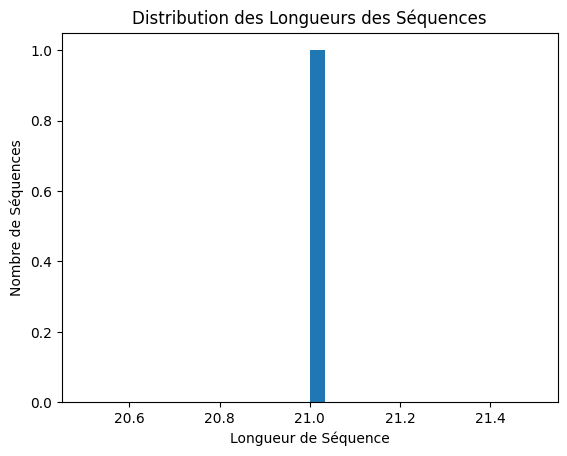

In [18]:
mean_length = np.mean(max_sequence_length)
max_length = np.max(max_sequence_length)
min_length = np.min(max_sequence_length)
std_dev = np.std(max_sequence_length)

# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(max_sequence_length, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()


In [19]:
# Calculer la taille du vocabulaire réel
vocab_size = len(tokenizer.word_index) + 1  # Ajoutez 1 pour tenir compte du padding

# Afficher la taille du vocabulaire
print("Taille réelle du vocabulaire:", vocab_size)

Taille réelle du vocabulaire: 42111


In [20]:
# Hyperparamètres et dimensions des données*
taille_num_features = scaled_df.shape[1]
taille_text_features = max_sequence_length # je donne la taille max parmi les longueur des sequences
vocab_size = vocab_size ### ici vu que j'utilise la tokenisation keras la taille du vocabulaires est en realaite le paramtre ['num_word] passer a mon tokeniser donc inutile cette ligne 
embedding_dim = 128

In [21]:
from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam




# Entrées
input_num = tf.keras.layers.Input(shape=(taille_num_features,))
input_text = tf.keras.layers.Input(shape=(taille_text_features,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(256, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(128, activation='relu')(num_branch)


# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

mask_inputs = masque_remplissage(input_text)

out_seq = Encodeur(
            n_layers=5,
            d_model=128,
            num_heads=2,
            middle_units=256,
            max_seq_len=taille_text_features)([text_branch, mask_inputs])
# out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.2)(out_seq)

# Fusion des branches

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])


# Couches supplémentaires après la fusion
merged = tf.keras.layers.Dropout(0.2)(merged)
merged = tf.keras.layers.Dense(64, activation='relu')(merged)
merged = tf.keras.layers.Dense(32, activation='relu')(merged)
merged = tf.keras.layers.Dense(16, activation='relu')(merged)

output = tf.keras.layers.Dense(4, activation='softmax')(merged)


# Création et compilation du modèle
model = Model(inputs=[input_num, input_text], outputs=output)

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          3328        ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 21, 128)      5390208     ['input_2[0][0]']                
                                                                                              

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Entrées pour l'entraînement
data_num = scaled_df
data_text = pad_sequences(tokens, maxlen=max_length,padding='post')

# Assurez-vous que les données numériques sont correctes
print("Shape of data_num:", data_num.shape)

# Assurez-vous que les données textuelles sont correctes après le rembourrage
print("Shape of data_text:", data_text.shape)

# Assurez-vous que les étiquettes sont correctes
print("Shape of labels:", y.shape)

# NB utiliser le resultat obtenu pour modifier les tailles ou dimension de mes entrées definie plus haut


# 6. Encodage des étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(y_encoded)

Shape of data_num: (1294792, 12)
Shape of data_text: (1294792, 21)
Shape of labels: (1294792,)
[3 2 2 ... 0 0 1]


In [22]:
# from sklearn.model_selection import train_test_split


# # Diviser les données en ensembles d'entraînement et de test
# X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical, y_train, y_test = train_test_split(data_num, data_text, y_encoded, test_size=0.20,random_state=42)

# #X_train_num, X_val_num, X_train_cate, X_val_cate, y_train, y_val = train_test_split(X_train_numerical, X_train_categorical, y_train, test_size=0.10, random_state=42)


# print("X_train_numerical")
# print(X_train_numerical.shape)
# print("X_train_categorical")
# print(X_train_categorical.shape)
# print("y_train")
# print(y_train.shape)
# print("X_test_numerical")
# print(X_test_numerical.shape)
# print("X_test_categorical")
# print(X_test_categorical.shape)
# print("y_test")
# print(y_test.shape)

# print("\n")

# #print(X_train_num.shape)
# #print(X_train_cate.shape)
# print(y_train.shape)



X_train_numerical
(426745, 12)
X_train_categorical
(426745, 21)
y_train
(426745,)
X_test_numerical
(106687, 12)
X_test_categorical
(106687, 21)
y_test
(106687,)


(426745,)


In [23]:
print(label_encoder.classes_)


['heavy_attacks' 'heavy_bengnin' 'light_attacks' 'light_bengnin']


In [24]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test (15% pour le test)
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    data_num, data_text, y_encoded, test_size=0.15, random_state=42
)

# Diviser l'ensemble d'entraînement en sous-ensembles d'entraînement et de validation (15% pour la validation)
X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_train_num, X_train_cat, y_train, test_size=0.15 / 0.85, random_state=42
)

# Entraîner le modèle avec les données d'entraînement et de validation
history = model.fit(
    [X_train_num, X_train_cat], y_train,
    epochs=10,
    batch_size=64,
    validation_data=([X_val_num, X_val_cat], y_val)
)


Train on 906354 samples, validate on 194219 samples
Epoch 1/10
669504/906354 [=====================>........] - ETA: 11:12 - loss: 1.0979 - accuracy: 0.4094

KeyboardInterrupt: 

In [ ]:
##################### NE PAS EXECUTER ################

#################### je passe les donnees par lots pour accelerer l'entrainement et economiser en memoire ########
### contraiment a la methode [model.fit(qui va charger tout les donnee en memoire durant le le training)]


from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X_num, X_text, y, batch_size):
        self.X_num = X_num
        self.X_text = X_text
        self.y = y
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.X_num))

    def __len__(self):
        return int(np.ceil(len(self.X_num) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, len(self.X_num))
        batch_X_num = self.X_num[start_index:end_index]
        batch_X_text = self.X_text[start_index:end_index]
        batch_y = self.y[start_index:end_index]
        return [batch_X_num, batch_X_text], batch_y


from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical, y_train, y_test = train_test_split(data_num, data_text, y_encoded, test_size=0.25, random_state=42)



batch_size = 128
train_generator = DataGenerator(X_train_numerical, X_train_categorical, y_train, batch_size)
validation_generator = DataGenerator(X_test_numerical, X_test_categorical, y_test, batch_size)


#### je call le generatuer de donneee pour l'entrainement ########

# Utilisation de fit() au lieu de fit_generator() (deprecated) ## doncj je dois remplcaer le fit_genrator par (fit())

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(X_train_numerical) // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=len(X_test_numerical) // batch_size
)


In [23]:
from sklearn.model_selection import train_test_split


##### cette methode est gourmenete etant donnee que jai pratiquement 1/2 million de donnee et seulememt 8 gb de ram ####
##### ce facon de proceder charge tout mes donnee en memoire durrant le trainig  ce qui n'est pas bon ; il faut utiliser un generateur  de donnee pour le training comme jai fais dans la cellule en haut ##
history = model.fit([X_train_num,X_train_cate], y_train, epochs=20, batch_size=32, validation_data=([X_val_num,X_val_cate], y_val))


Train on 155456 samples, validate on 17273 samples
Epoch 1/20
155456/155456 [==============================] - ETA: 0s - loss: 1.1009 - accuracy: 0.4069

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


155456/155456 [==============================] - 1022s 7ms/sample - loss: 1.1009 - accuracy: 0.4069 - val_loss: 1.0966 - val_accuracy: 0.4096
Epoch 2/20
 48512/155456 [========>.....................] - ETA: 11:51 - loss: 1.0965 - accuracy: 0.4090

KeyboardInterrupt: 

pip install keras-tuner

########## POUR LES HYPERPARAMETRE TUNING #############


In [44]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split

taille_num_features = taille_num_features  
taille_text_features = taille_text_features  
vocab_size = vocab_size  
    

def build_model(hp):
    
    input_num = Input(shape=(taille_num_features,))
    input_text = Input(shape=(taille_text_features,))

    # Branche numérique - FFN
    num_branch = Dense(units=hp.Int('num_units_1', min_value=64, max_value=512, step=64), activation='relu')(input_num)
    num_branch = BatchNormalization()(num_branch)
    num_branch = Dropout(rate=hp.Float('num_dropout_1', min_value=0.1, max_value=0.5, step=0.1))(num_branch)
    num_branch = Dense(units=hp.Int('num_units_2', min_value=64, max_value=256, step=64), activation='relu')(num_branch)
    num_branch = BatchNormalization()(num_branch)
    num_branch = Dropout(rate=hp.Float('num_dropout_2', min_value=0.1, max_value=0.5, step=0.1))(num_branch)

    # Branche textuelle - Embedding + Transformer
    embedding_dim = hp.Choice('embedding_dim', values=[128, 256, 512])
    text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)
    mask_inputs = masque_remplissage(input_text)
    out_seq = Encodeur(
                n_layers=hp.Int('n_layers', 1, 6, step=1),
                d_model=embedding_dim,
                num_heads=hp.Choice('num_heads', values=[4, 8, 16]),
                middle_units=hp.Int('middle_units', 128, 512, step=128),
                max_seq_len=taille_text_features)([text_branch, mask_inputs])
    out_seq = GlobalAveragePooling1D()(out_seq)
    out_seq = Dropout(rate=hp.Float('transformer_dropout', 0.1, 0.5, step=0.1))(out_seq)

    merged = concatenate([num_branch, out_seq])

    # Couches supplémentaires après la fusion
    merged = Dense(units=hp.Int('merged_units_1', 64, 256, step=64), activation='relu')(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(rate=hp.Float('merged_dropout_1', 0.1, 0.5, step=0.1))(merged)
    merged = Dense(units=hp.Int('merged_units_2', 32, 128, step=32), activation='relu')(merged)
    merged = BatchNormalization()(merged)
    merged = Dropout(rate=hp.Float('merged_dropout_2', 0.1, 0.5, step=0.1))(merged)
    merged = Dense(32, activation='relu')(merged)

    output = Dense(4, activation='softmax')(merged)

    model = Model(inputs=[input_num, input_text], outputs=output)

    opt = Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Définir la recherche d'hyperparamètres
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband',
    project_name='text_numerical_model_tuning'
)

# Diviser les données en ensembles d'entraînement et de validation
X_train_numerical, X_val_numerical, X_train_categorical, X_val_categorical, y_train, y_val = train_test_split(
    data_num, data_text, y_encoded, test_size=0.25, random_state=42)

# Préparation des  données pour le tuner
train_data = [X_train_numerical, X_train_categorical]
val_data = [X_val_numerical, X_val_categorical]

# Lancer la recherche d'hyperparamètres
tuner.search(train_data, y_train, epochs=10, validation_data=(val_data, y_val), batch_size=32)

# résultats
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Les meilleurs hyperparamètres sont :
- embedding_dim : {best_hps.get('embedding_dim')}
- num_units_1 : {best_hps.get('num_units_1')}
- num_dropout_1 : {best_hps.get('num_dropout_1')}
- num_units_2 : {best_hps.get('num_units_2')}
- num_dropout_2 : {best_hps.get('num_dropout_2')}
- n_layers : {best_hps.get('n_layers')}
- num_heads : {best_hps.get('num_heads')}
- middle_units : {best_hps.get('middle_units')}
- transformer_dropout : {best_hps.get('transformer_dropout')}
- merged_units_1 : {best_hps.get('merged_units_1')}
- merged_dropout_1 : {best_hps.get('merged_dropout_1')}
- merged_units_2 : {best_hps.get('merged_units_2')}
- merged_dropout_2 : {best_hps.get('merged_dropout_2')}
- learning_rate : {best_hps.get('learning_rate')}
""")


Reloading Tuner from hyperband\text_numerical_model_tuning\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
320               |320               |num_units_1
0.1               |0.1               |num_dropout_1
256               |256               |num_units_2
0.5               |0.5               |num_dropout_2
512               |512               |embedding_dim
5                 |5                 |n_layers
4                 |4                 |num_heads
128               |128               |middle_units
0.2               |0.2               |transformer_dropout
256               |256               |merged_units_1
0.5               |0.5               |merged_dropout_1
64                |64                |merged_units_2
0.1               |0.1               |merged_dropout_2
0.0003033         |0.0003033         |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2           

In [20]:
from sklearn.metrics import classification_report


# Évaluation du modèle sur les données de test
evaluation_results = model.evaluate([X_test_numerical, X_test_categorical], y_test)

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])

#on effectue les prediction sur les donnees de test

y_pred = model.predict([X_test_numerical, X_test_categorical])

print(y_pred)


# Convertir les indices des classes prédites en étiquettes
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher le rapport de classification
class_report = classification_report(y_test, y_pred_classes)
print("Rapport de classification :\n", class_report)


Perte sur les données de test: 0.6193836101729409
Précision sur les données de test: 0.80855


c:\python install\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[7.9097688e-01 8.4833212e-02 1.2417506e-01 1.4918560e-05]
 [7.9097688e-01 8.4833212e-02 1.2417506e-01 1.4918560e-05]
 [7.9097688e-01 8.4833212e-02 1.2417506e-01 1.4918560e-05]
 ...
 [7.9097688e-01 8.4833212e-02 1.2417506e-01 1.4918560e-05]
 [7.9097688e-01 8.4833212e-02 1.2417506e-01 1.4918560e-05]
 [7.9097688e-01 8.4833212e-02 1.2417506e-01 1.4918560e-05]]


c:\python install\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python install\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python install\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rapport de classification :
               precision    recall  f1-score   support

           0       0.81      1.00      0.89    108374
           1       0.00      0.00      0.00     10699
           2       0.00      0.00      0.00     14962

    accuracy                           0.81    134035
   macro avg       0.27      0.33      0.30    134035
weighted avg       0.65      0.81      0.72    134035



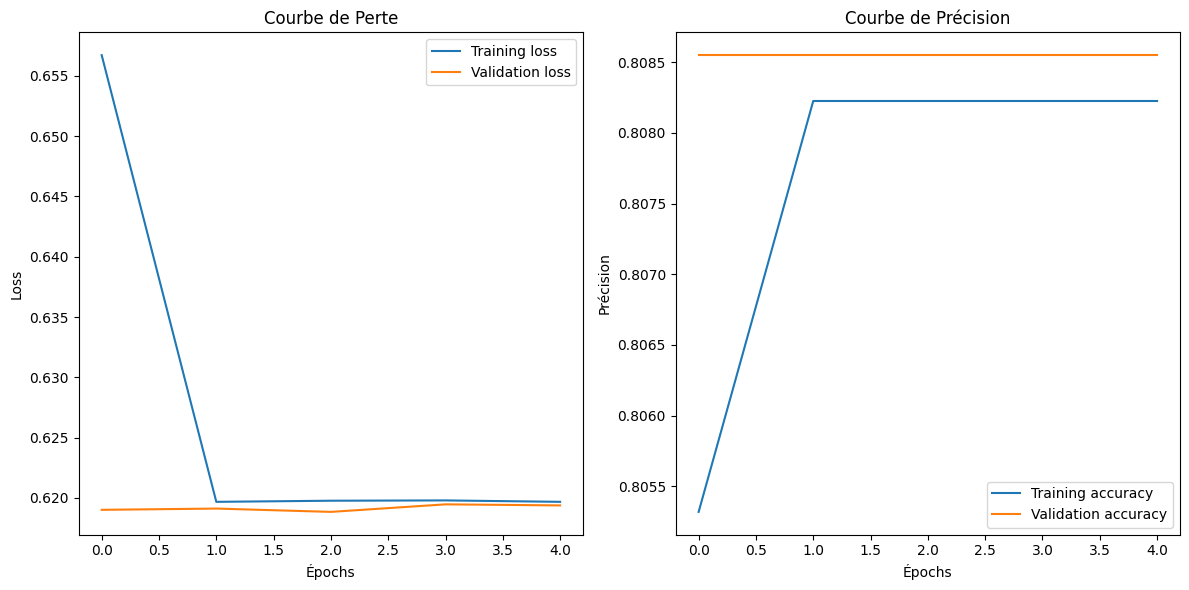

In [21]:
# Extraction des métriques d'entraînement
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_curve, auc



# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)
# class_names = ['heavy attacks', 'heavy bengnin', 'light attacks', 'light bengnin']

class_names = ['heavy_attacks', 'heavy_bengnin', 'light_attacks', 'light_bengnin']

df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()